In [1]:
# Add the relevant scripts from LArMachineLearningData
# Nice the process so it can run with lots of cores on low priority
import os
os.nice(20)

# Add local paths
import sys
hnlDIR = os.environ['_']
sys.path.append('../pyscript')

# From pyscript Library
from Plotting import *
from Dictionary import *
from HelperFunctions import *
from CutFunctions import *

import pickle
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import warnings
warnings.filterwarnings("ignore")

<h1>Configuration Stuff Here</h1>

In [2]:
m = 240

ifSave = True
savePath = "../plot_files/05Mar2024_m"+str(m)+"_systematics/"

In [3]:
unisim_list = [ 'slc_xsec_unisim_DecayAngMEC', 
               'slc_xsec_unisim_ThetaDelta2NRad',
               'slc_xsec_unisim_Theta_Delta2Npi', 
               'slc_xsec_unisim_VecFFCCQEshape',]

multisigma_list = [
        'slc_xsec_multisigma_CoulombCCQE',
       'slc_xsec_multisigma_NonRESBGvbarnCC1pi',
       'slc_xsec_multisigma_NonRESBGvbarnCC2pi',
       'slc_xsec_multisigma_NonRESBGvbarnNC1pi',
       'slc_xsec_multisigma_NonRESBGvbarnNC2pi',
       'slc_xsec_multisigma_NonRESBGvbarpCC1pi',
       'slc_xsec_multisigma_NonRESBGvbarpCC2pi',
       'slc_xsec_multisigma_NonRESBGvbarpNC1pi',
       'slc_xsec_multisigma_NonRESBGvbarpNC2pi',
       'slc_xsec_multisigma_NonRESBGvnCC1pi',
       'slc_xsec_multisigma_NonRESBGvnCC2pi',
       'slc_xsec_multisigma_NonRESBGvnNC1pi',
       'slc_xsec_multisigma_NonRESBGvnNC2pi',
       'slc_xsec_multisigma_NonRESBGvpCC1pi',
       'slc_xsec_multisigma_NonRESBGvpCC2pi',
       'slc_xsec_multisigma_NonRESBGvpNC1pi',
       'slc_xsec_multisigma_NonRESBGvpNC2pi', 
       'slc_xsec_multisigma_NormCCMEC',
       'slc_xsec_multisigma_NormNCMEC', 
       'slc_xsec_multisigma_RDecBR1eta',
       'slc_xsec_multisigma_RDecBR1gamma', 
       'slc_xsec_multisigma_RPA_CCQE',
       'slc_xsec_multisigma_NormNCCOH', 
       'slc_xsec_multisigma_NormCCCOH',
]

<h1> Read in PKL Dataframe </h1>

<h3>HNL</h3>

In [ ]:
hnl_path = "./df_m"+str(m)+"_v2_hnl.pkl"

file = open(hnl_path, 'rb')
df_hnl = pickle.load(file)
file.close
del hnl_path

In [ ]:
df_hnl = df_hnl[["run", "subrun", "event", "slc_idx", "scale_pot", "mod_t", 'slc_comp', 'slc_true_event_type']]

<h3>TPC Neutrino</h3>

In [ ]:
nu_path = "./df_m"+str(m)+"_v2_nu.pkl"

file = open(nu_path, 'rb')
df_nu = pickle.load(file)
file.close
del nu_path

In [ ]:
df_nu = df_nu[["run", "subrun", "event", "slc_idx", "scale_pot", "mod_t", 'slc_comp', 'slc_true_event_type']]

<h3>Intime Cosmics</h3>

In [ ]:
cos_path = "./df_m"+str(m)+"_v2_cos.pkl"

file = open(cos_path, 'rb')
df_cos = pickle.load(file)
file.close
del cos_path

In [ ]:
df_cos = df_cos[["run", "subrun", "event", "slc_idx", "scale_pot", "mod_t", 'slc_comp', 'slc_true_event_type']]

<h1> Load Flux Systematics</h1>

<h3> HNL </h3>

In [ ]:
dfw_hnl = pd.DataFrame()

print(len(df_hnl))

for i in range(0, 5):  
    hnl_path = "../pkl_files/v2/hnl_m"+str(m)+"_50k_v2_flxw_{}.pkl".format(i)
    print(hnl_path)
    
    file = open(hnl_path, 'rb')   
    df = pickle.load(file)
    df = df[['run','subrun','event','slc_idx','slc_flux_weight_total']]

    print(df[(df['run'] == 1) & (df['subrun']==790) & (df['event']==39)])
    
    df = df.merge(df_hnl, how='inner', on=['run','subrun','event','slc_idx'])
    
    print(len(df))
    print(len(df_hnl))
    dfw_hnl = pd.concat((dfw_hnl, df), ignore_index=True)
    file.close()
    
del df_hnl

print(len(dfw_hnl))

<h3> TPC Neutrino </h3>

In [ ]:
dfw_nu = pd.DataFrame()

print(len(df_nu))

for i in range(0, 10):
    nu_path = "../pkl_files/v2/nu_rockbox_100k_v2_flxw_{}.pkl".format(i)
    print(nu_path)
    
    file = open(nu_path, 'rb')
    df = pickle.load(file)
    df = df.merge(df_nu, how='inner', on=['run','subrun','event','slc_idx'])
    
    dfw_nu = pd.concat((dfw_nu, df), ignore_index=True)
    file.close()
    
del df_nu

print(len(dfw_nu))

<h1>Manipulate Dataframe</h1>

<h3>Flux Weights </h3>

In [ ]:
def make_df_flxw(df):
    
    #explode array into columns
    df_flxw = pd.DataFrame(df['slc_flux_weight_total'].tolist(),index=df.index).add_prefix('flxw_')
    
    #drop column
    df = df.drop(columns='slc_flux_weight_total')

    #merge 2 arrays together
    df = pd.concat([df, df_flxw], axis = 1)
    
    #add nominal flux weight = 1
    df['flxw_nom'] = 1
    
    del df_flxw
    return df

In [ ]:
dfw_hnl = make_df_flxw(dfw_hnl)
dfw_nu = make_df_flxw(dfw_nu)

In [ ]:
#Check for NAN
nan_df = dfw_hnl[dfw_hnl.flxw_0 != dfw_hnl.flxw_0]
nan_df

In [ ]:
#Keep non-NAN for now
dfw_hnl = dfw_hnl[dfw_hnl.flxw_0 == dfw_hnl.flxw_0]
dfw_hnl

<h3>Neutrino Cross Section Systematics</h3>

In [ ]:
def check_unisim(row):
    val = 1
    if len(row) > 0:
        val = row[0]
        if val == -9999:
            val = 1
    return val

In [ ]:
def check_multisigma_neg1(row):
    val = 1
    if len(row) > 0:
        val = row[0]
        if val == -9999:
            val = 1
    return val

In [ ]:
def check_multisigma_pos1(row):
    val = 1
    if len(row) > 0:
        val = row[1]
        if val == -9999:
            val = 1
    return val

In [ ]:
def make_df_xsecw(df):
    
    for name in unisim_list:
        df[name] = df[name].apply(lambda row: check_unisim(row))
    
    for name in multisigma_list:
        df[name+'_neg1'] = df[name].apply(lambda row: check_multisigma_neg1(row))
        df[name+'_pos1'] = df[name].apply(lambda row: check_multisigma_pos1(row))
        df = df.drop([name], axis = 1)
    
    #explode array into columns
    df_xsecw = pd.DataFrame(df['slc_xsec_multisim_total'].tolist(),index=df.index).add_prefix('xsecw_')
    
    #drop column
    df = df.drop(columns='slc_xsec_multisim_total')

    #merge 2 arrays together
    df = pd.concat([df, df_xsecw], axis = 1)
    
    #add nominal flux weight = 1
    df['xsec_nom'] = 1
    
    #explode array into columns
    df_g4w = pd.DataFrame(df['slc_geant4_multisim_reinteractions'].tolist(),index=df.index).add_prefix('g4w_')
    
    #drop column
    df = df.drop(columns='slc_geant4_multisim_reinteractions')

    #merge 2 arrays together
    df = pd.concat([df, df_g4w], axis = 1)
    
    #add nominal flux weight = 1
    df['g4_nom'] = 1
    
    return df


In [ ]:
dfw_nu = make_df_xsecw(dfw_nu)

In [ ]:
#fill cosmic weight with 1
dfw_nu = dfw_nu.fillna(1)
dfw_nu

In [ ]:
for name in multisigma_list:
    print()
    print(dfw_nu[name + "_pos1"])
    print(dfw_nu[name + "_neg1"])

<h1>SAVE THIS DATAFRAME</h1>

In [ ]:
dfw_hnl.to_pickle("./df_hnl_m"+str(m)+"_v2_weight.pkl", protocol = 5)
dfw_nu.to_pickle("./df_nu_m"+str(m)+"_v2_weight.pkl", protocol = 5)
df_cos.to_pickle("./df_cos_m"+str(m)+"_v2_weight.pkl", protocol = 5)

<h1> START FROM HERE!!! LOAD PKL FILE WITH FLX WEIGHT ADDED </h1>

<h3>HNL</h3>

In [4]:
file = open("./df_hnl_m"+str(m)+"_v2_weight.pkl", 'rb')
df_hnl = pickle.load(file)
file.close()

<h3>TPC Neutrino</h3>

In [5]:
file = open("./df_nu_m"+str(m)+"_v2_weight.pkl", 'rb')
df_nu = pickle.load(file)
file.close()

<h3>Intime Cosmics</h3>

In [6]:
file = open("./df_cos_m"+str(m)+"_v2_weight.pkl", 'rb')
df_cos = pickle.load(file)
file.close()

<h3> Configure some plots stuff </h3> 

In [7]:
xmin = 10
xmax = 19
xnbin = 10

hnl_ymin = 0
hnl_ymax = 60

nu_ymin = 0
nu_ymax = 500



<h3> Organise Some Stuff</h3>

In [8]:
hnl_dict = {}
nu_dict = {}

<h1> Make Beam Bucket - Post PID</h1>

In [9]:
true_counts = 1
start_counts = 1
simU = 1

if m == 140:
    simU = 1e-5
    scaleHNLPlot = 3.7
    true_counts = 32240.456491241213
    start_counts = 30011.11138541757
    
if m == 200:
    simU=1e-7
    scaleHNLPlot = 80
    true_counts = 1491.8413161003443
    start_counts = 1372.3745440402568
    
if m == 240:
    simU = 1e-7
    scaleHNLPlot = 17.2
    true_counts = 6935.57810442791
    start_counts = 6380.176454423673

In [10]:
plotU = getUfromScaleFactor(simU, scaleHNLPlot)

true_counts = true_counts * scaleHNLPlot
start_counts =  start_counts * scaleHNLPlot

print("Scale Umu by " + str(scaleHNLPlot))
print("Scaled Umu = " + str(plotU))
print("Scaled true counts = " + str(true_counts))
print("Scaled start counts = " + str(start_counts))

Scale Umu by 17.2
Scaled Umu = 4.147288270665544e-07
Scaled true counts = 119291.94339616004
Scaled start counts = 109739.03501608717


<Figure size 432x288 with 0 Axes>

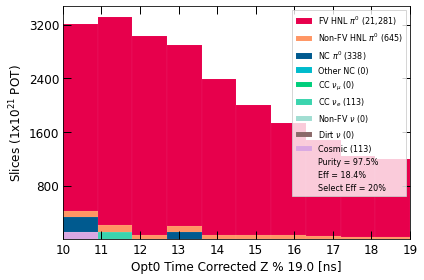

In [11]:
width = 19.00


hist, bins = plot_slc_var(df_hnl, df_nu, df_cos,
                    true_counts, start_counts, 
                    'mod_t', 
                    scaleHNLPlot,
                    xmin = xmin, xmax = xmax, xnbin = xnbin,
                    xtitle = 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]'
                    )
plt.show()

<h1>Statistics Uncertainty</h1>

<h3>HNL</h3>

<h3>Scaling to ~10 events for hypothesis testing </h3>

In [12]:
scaleFit= 1/100

fitU = getUfromScaleFactor(plotU, scaleFit)

print("Simulated U = " + str(simU))
print("Plot U = " + str(plotU))
print("Fit U = " + str(fitU))

df_hnl['scaleFit'] = scaleFit

Simulated U = 1e-07
Plot U = 4.147288270665544e-07
Fit U = 4.147288270665544e-08


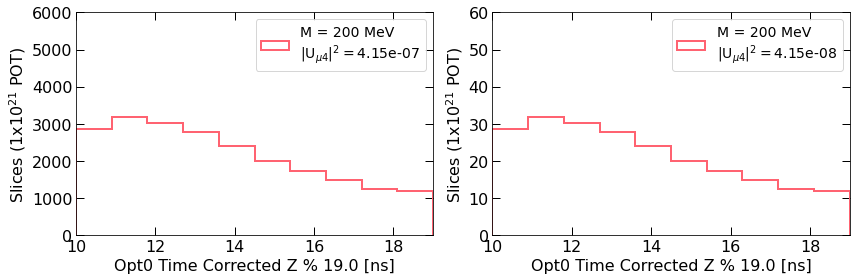

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

pltdf = df_hnl['mod_t']
weights = df_hnl['scale_pot'] 

#-----------------------------------------------------------------#
hnl_stat_noScale, bins, _ = ax1.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["Flamingo"],
                            linestyle = "-",
                            linewidth = 2,
                            label = "M = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(plotU))
                        )

ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax/scaleFit)
#-----------------------------------------------------------------#
weights = df_hnl['scale_pot'] * df_hnl['scaleFit']
hnl_stat, _, _ = ax2.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["Flamingo"],
                            linestyle = "-",
                            linewidth = 2,
                            label = "M = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(fitU))
                        )

ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(hnl_ymin, hnl_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

plt.show()

In [14]:
#Scale
print(hnl_stat)
hnl_stat_err = np.sqrt(hnl_stat)
print(hnl_stat_err)


#No Scale
print(hnl_stat_noScale)
hnl_stat_noScale_err = np.sqrt(hnl_stat_noScale)
print(hnl_stat_noScale_err)


#make array for plotting
hnl_stat_plot = np.insert(hnl_stat, 0, 0)
hnl_stat_noScale_plot = np.insert(hnl_stat_noScale, 0, 0)

bins_mid = np.convolve(bins, [0.5, 0.5], "valid")

[28.65872514 31.93059626 30.30660184 27.84672793 23.95391776 20.08498987
 17.36241098 14.80700799 12.39489862 12.01278229]
[5.35338446 5.65071644 5.50514322 5.2769999  4.89427398 4.48162804
 4.16682265 3.84798752 3.52063895 3.46594609]
[2865.87251402 3193.05962604 3030.66018358 2784.67279279 2395.3917763
 2008.49898691 1736.24109808 1480.70079891 1239.48986232 1201.27822879]
[53.53384457 56.50716438 55.05143217 52.76999898 48.94273977 44.81628038
 41.66822648 38.47987525 35.20638951 34.65946088]


In [15]:
hnl_dict['hnl_cv'] = hnl_stat
hnl_dict['hnl_cv_plot'] = hnl_stat_plot
hnl_dict['bins'] = bins
hnl_dict['bins_mid'] = bins_mid

hnl_dict['neg_stat_err']= hnl_stat_err
hnl_dict['pos_stat_err']= hnl_stat_err

hnl_dict

{'hnl_cv': array([28.65872514, 31.93059626, 30.30660184, 27.84672793, 23.95391776,
        20.08498987, 17.36241098, 14.80700799, 12.39489862, 12.01278229]),
 'hnl_cv_plot': array([ 0.        , 28.65872514, 31.93059626, 30.30660184, 27.84672793,
        23.95391776, 20.08498987, 17.36241098, 14.80700799, 12.39489862,
        12.01278229]),
 'bins': array([10. , 10.9, 11.8, 12.7, 13.6, 14.5, 15.4, 16.3, 17.2, 18.1, 19. ]),
 'bins_mid': array([10.45, 11.35, 12.25, 13.15, 14.05, 14.95, 15.85, 16.75, 17.65,
        18.55]),
 'neg_stat_err': array([5.35338446, 5.65071644, 5.50514322, 5.2769999 , 4.89427398,
        4.48162804, 4.16682265, 3.84798752, 3.52063895, 3.46594609]),
 'pos_stat_err': array([5.35338446, 5.65071644, 5.50514322, 5.2769999 , 4.89427398,
        4.48162804, 4.16682265, 3.84798752, 3.52063895, 3.46594609])}

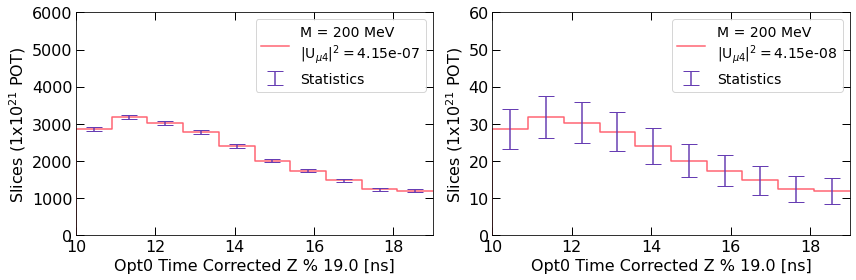

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

#-----------------------------------------------------------------#
#nStat NoScale
ax1.step(bins, hnl_stat_noScale_plot
         , color = col_dict['Flamingo']
         , label =  "M = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(plotU))
        )

ax1.errorbar(bins_mid, hnl_stat_noScale, hnl_stat_noScale_err,
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#

ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax/scaleFit)
#-----------------------------------------------------------------#

ax2.step(bins, hnl_dict['hnl_cv_plot']
         , color = col_dict['Flamingo']
         , label =  "M = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(fitU))
        )

ax2.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_stat_err'], hnl_dict['pos_stat_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#
ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(hnl_ymin, hnl_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_statistics_error.png"), dpi=200)
    
plt.show()

<h3>Neutrino</h3>

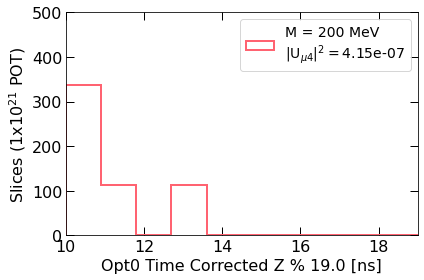

In [18]:
fig, ax1 = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

pltdf = df_nu['mod_t']
weights = df_nu['scale_pot'] 

#-----------------------------------------------------------------#
nu_stat, _, _ = ax1.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["Flamingo"],
                            linestyle = "-",
                            linewidth = 2,
                            label = "M = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(plotU))
                        )
ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#

fig.tight_layout()

plt.show()

In [19]:
#Scale

print(nu_stat)
nu_stat_err = np.sqrt(nu_stat)
print(nu_stat_err)

#make array for plotting
nu_stat_plot = np.insert(nu_stat, 0, 0)
#bins_mid = np.convolve(bins, [0.5, 0.5], "valid")

[338.11556274 112.70518758   0.         112.70518758   0.
   0.           0.           0.           0.           0.        ]
[18.38791893 10.61626995  0.         10.61626995  0.          0.
  0.          0.          0.          0.        ]


In [20]:
nu_dict['nu_cv'] = nu_stat
nu_dict['nu_cv_plot'] = nu_stat_plot
nu_dict['bins'] = bins
nu_dict['bins_mid'] = bins_mid

nu_dict['neg_stat_err']= nu_stat_err
nu_dict['pos_stat_err']= nu_stat_err


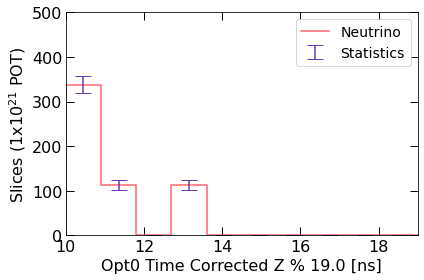

In [21]:
fig, ax1 = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

#-----------------------------------------------------------------#
ax1.step(bins, nu_dict['nu_cv_plot']
         , color = col_dict['Flamingo']
         , label =  "Neutrino")
        
#-----------------------------------------------------------------#
ax1.errorbar(bins_mid, nu_dict['nu_cv']
             , [nu_dict['neg_stat_err'], nu_dict['pos_stat_err']],
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_statistics_error.png"), dpi=200)
    
plt.show()

<h1>Flux Weights</h1>

<h3>Calculate Median and Value at 68 percentile</h3>

In [22]:
def get_median_68_quantile(n_cv, n_arr):
    print("CV array")
    n_cv = np.array(n_cv)
    print(n_cv)

    #check shape
    print("Weight array shape")
    n_arr = np.array(n_arr)
    print(n_arr.shape)

    print('\n Median')
    print(np.median(n_arr, axis=0))
    median = np.median(n_arr, axis=0)
    
    print('\n Low 34.1 quantile')
    print(np.percentile(n_arr, 15.87, axis=0))
    low_flux = np.percentile(n_arr, 15.87, axis=0)

    print('\n High 34.1 quantile')
    print(np.percentile(n_arr, 84.13, axis=0))
    high_flux = np.percentile(n_arr, 84.13, axis=0)

    print('\n Standard Error')
    flx_err = [abs(n_cv - low_flux), abs(high_flux - n_cv)]
    flx_err = np.array(flx_err)
    print(flx_err)
    
    median = np.array(median)
    flx_err = np.array(flx_err)
    return median, flx_err

<h3>HNL</h3>

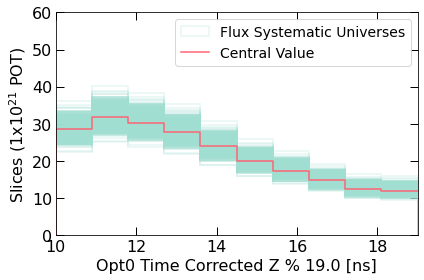

In [23]:
hnl_flx_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_hnl['mod_t']

for i in range(0, 1000):
    weights = df_hnl['scale_pot'] * df_hnl['scaleFit'] * df_hnl['flxw_{}'.format(i)]
    label = ''
    if i == 0:
        label = "Flux Systematic Universes"
        
    hnl_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    hnl_flx_universe.append(hnl_n)
#-----------------------------------------------------------------#
#Central Value
ax.step(bins, hnl_dict['hnl_cv_plot']
         , color = col_dict['Flamingo']
         , label =  "Central Value"
        )
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(hnl_ymin, hnl_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_flux_weight_universe.png"), dpi=200)
plt.show()

In [24]:
hnl_flx_universe = np.array(hnl_flx_universe)
hnl_flx_universe = np.sort(hnl_flx_universe, axis = 0)

hnl_flx_median, hnl_flx_err = get_median_68_quantile(hnl_dict['hnl_cv'], hnl_flx_universe)

#make array for plotting
hnl_flx_median_plot = np.insert(hnl_flx_median, 0, 0)

CV array
[28.65872514 31.93059626 30.30660184 27.84672793 23.95391776 20.08498987
 17.36241098 14.80700799 12.39489862 12.01278229]
Weight array shape
(1000, 10)

 Median
[28.56964171 31.78761286 30.34259384 27.85574045 24.04533929 20.18938204
 17.62457471 15.0007847  12.67515798 12.31185759]

 Low 34.1 quantile
[26.73395511 29.78889378 28.35205371 26.0584597  22.48861884 18.84685573
 16.42299736 14.01416942 11.78977928 11.44343184]

 High 34.1 quantile
[30.47979947 33.87516614 32.32596501 29.72793013 25.63971378 21.54578748
 18.83231513 16.03681802 13.59142666 13.20822856]

 Standard Error
[[1.92477003 2.14170248 1.95454813 1.78826823 1.46529893 1.23813414
  0.93941363 0.79283857 0.60511934 0.56935044]
 [1.82107433 1.94456988 2.01936317 1.8812022  1.68579602 1.46079761
  1.46990415 1.22981003 1.19652803 1.19544627]]


In [25]:
hnl_dict['neg_flx_err'] = hnl_flx_err[0]
hnl_dict['pos_flx_err'] = hnl_flx_err[1]

hnl_dict

{'hnl_cv': array([28.65872514, 31.93059626, 30.30660184, 27.84672793, 23.95391776,
        20.08498987, 17.36241098, 14.80700799, 12.39489862, 12.01278229]),
 'hnl_cv_plot': array([ 0.        , 28.65872514, 31.93059626, 30.30660184, 27.84672793,
        23.95391776, 20.08498987, 17.36241098, 14.80700799, 12.39489862,
        12.01278229]),
 'bins': array([10. , 10.9, 11.8, 12.7, 13.6, 14.5, 15.4, 16.3, 17.2, 18.1, 19. ]),
 'bins_mid': array([10.45, 11.35, 12.25, 13.15, 14.05, 14.95, 15.85, 16.75, 17.65,
        18.55]),
 'neg_stat_err': array([5.35338446, 5.65071644, 5.50514322, 5.2769999 , 4.89427398,
        4.48162804, 4.16682265, 3.84798752, 3.52063895, 3.46594609]),
 'pos_stat_err': array([5.35338446, 5.65071644, 5.50514322, 5.2769999 , 4.89427398,
        4.48162804, 4.16682265, 3.84798752, 3.52063895, 3.46594609]),
 'neg_flx_err': array([1.92477003, 2.14170248, 1.95454813, 1.78826823, 1.46529893,
        1.23813414, 0.93941363, 0.79283857, 0.60511934, 0.56935044]),
 'pos_flx_err

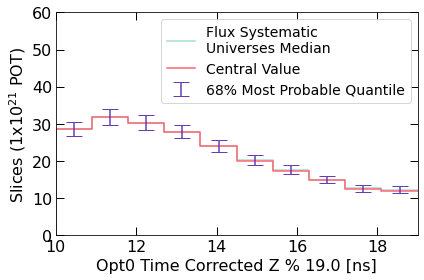

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, hnl_flx_median_plot, color = col_dict['PastelGreen'], label = "Flux Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_flx_err'], hnl_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(hnl_ymin, hnl_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_flux_weight_median68.png"), dpi=200)
plt.show()

<h3>Neutrino</h3>

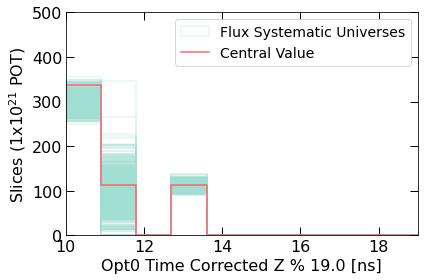

In [27]:
nu_flx_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_nu['mod_t']

for i in range(0, 1000):
    weights = df_nu['scale_pot'] * df_nu['flxw_{}'.format(i)]
    label = ''
    if i == 0:
        label = "Flux Systematic Universes"
        
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    nu_flx_universe.append(nu_n)
#-----------------------------------------------------------------#
#Central Value
ax.step(bins, nu_dict['nu_cv_plot']
         , color = col_dict['Flamingo']
         , label =  "Central Value"
        )
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_flux_weight_universe.png"), dpi=200)
plt.show()

In [28]:
nu_flx_universe = np.array(nu_flx_universe)
nu_flx_universe = np.sort(nu_flx_universe, axis = 0)

nu_flx_median, nu_flx_err = get_median_68_quantile(nu_dict['nu_cv'], nu_flx_universe)

#make array for plotting
nu_flx_median_plot = np.insert(nu_flx_median, 0, 0)

CV array
[338.11556274 112.70518758   0.         112.70518758   0.
   0.           0.           0.           0.           0.        ]
Weight array shape
(1000, 10)

 Median
[298.90145743  97.2056964    0.         110.11950778   0.
   0.           0.           0.           0.           0.        ]

 Low 34.1 quantile
[281.03015733  61.6267492    0.         102.78074725   0.
   0.           0.           0.           0.           0.        ]

 High 34.1 quantile
[318.00006569 133.41533911   0.         118.10591988   0.
   0.           0.           0.           0.           0.        ]

 Standard Error
[[57.08540541 51.07843838  0.          9.92444033  0.          0.
   0.          0.          0.          0.        ]
 [20.11549705 20.71015153  0.          5.4007323   0.          0.
   0.          0.          0.          0.        ]]


In [29]:
nu_dict['neg_flx_err'] = nu_flx_err[0]
nu_dict['pos_flx_err'] = nu_flx_err[1]

nu_dict

{'nu_cv': array([338.11556274, 112.70518758,   0.        , 112.70518758,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]),
 'nu_cv_plot': array([  0.        , 338.11556274, 112.70518758,   0.        ,
        112.70518758,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]),
 'bins': array([10. , 10.9, 11.8, 12.7, 13.6, 14.5, 15.4, 16.3, 17.2, 18.1, 19. ]),
 'bins_mid': array([10.45, 11.35, 12.25, 13.15, 14.05, 14.95, 15.85, 16.75, 17.65,
        18.55]),
 'neg_stat_err': array([18.38791893, 10.61626995,  0.        , 10.61626995,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'pos_stat_err': array([18.38791893, 10.61626995,  0.        , 10.61626995,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'neg_flx_err': array([57.08540541, 51.07843838,  0.        ,  9.92444033,  0.        ,
         0.        ,  0.       

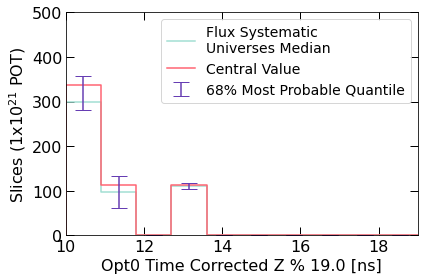

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_flx_median_plot, color = col_dict['PastelGreen'], label = "Flux Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_flx_err'] ,nu_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_flux_weight_median68.png"), dpi=200)
plt.show()

<h1>Cross Section Weights</h1>

In [31]:
if m == 140:
    nu_ymin = -30

<h3>Uni Sim</h3>

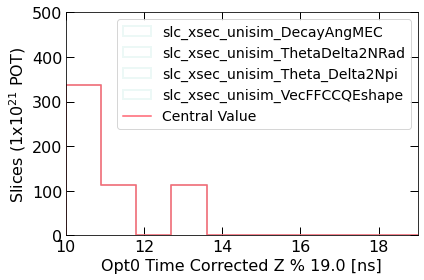

In [32]:
nu_unisim_arr = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_nu['mod_t']
weights = df_nu['scale_pot'] * df_nu['xsec_nom']
    
for name in unisim_list:
    weights = df_nu['scale_pot'] * df_nu[name]
    
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = name
                        )
    nu_unisim_arr.append(nu_n)
    
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_unisim_xsec_weight_universe.png"), dpi=200)
plt.show()

In [33]:
#Should be 4 unisim
nu_unisim_arr = np.array(nu_unisim_arr)
nu_unisim_err = nu_unisim_arr - nu_dict['nu_cv']
nu_unisim_err

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [34]:
#TODO: Unisim - IGNORE FOR NOW
#nu_err['neg_flx_err'] = nu_flx_err[0]
#nu_err

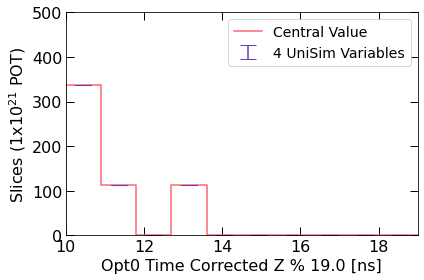

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

#-----------------------------------------------------------------#

#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#TODO: CURRENTLY PLOTTING 
#universe 1 sigma
for i in range(0, nu_unisim_err.shape[0]):
    label = ""
    if i == 0:
        label = '4 UniSim Variables'
    ax.errorbar(bins_mid, nu_dict['nu_cv']
                , yerr=(np.maximum(0, - nu_unisim_err[i]), np.maximum(0, nu_unisim_err[i]))
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
                )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_unisim_1direction.png"), dpi=200)
plt.show()

<h3>Multi Sigma</h3>

In [36]:
for name in multisigma_list:
    print(df_nu[name + "_pos1"])
    print(df_nu[name + "_neg1"])

0    1.000000
1    1.000000
2    0.996758
3    1.000000
4    1.000000
Name: slc_xsec_multisigma_CoulombCCQE_pos1, dtype: float64
0    1.000000
1    1.000000
2    1.003235
3    1.000000
4    1.000000
Name: slc_xsec_multisigma_CoulombCCQE_neg1, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: slc_xsec_multisigma_NonRESBGvbarnCC1pi_pos1, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: slc_xsec_multisigma_NonRESBGvbarnCC1pi_neg1, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: slc_xsec_multisigma_NonRESBGvbarnCC2pi_pos1, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: slc_xsec_multisigma_NonRESBGvbarnCC2pi_neg1, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: slc_xsec_multisigma_NonRESBGvbarnNC1pi_pos1, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: slc_xsec_multisigma_NonRESBGvbarnNC1pi_neg1, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: slc_xsec_multisigma_NonRE

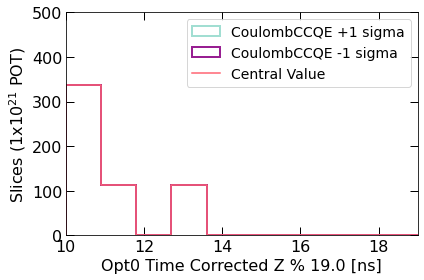

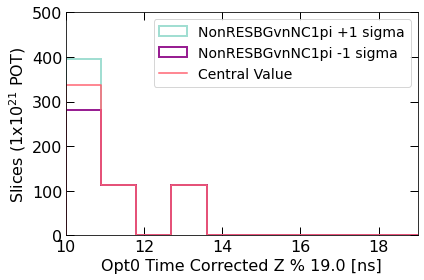

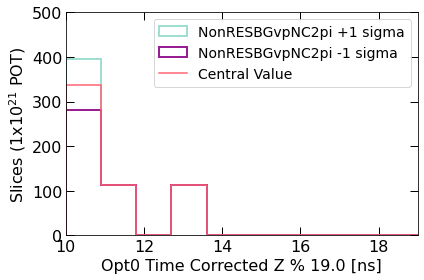

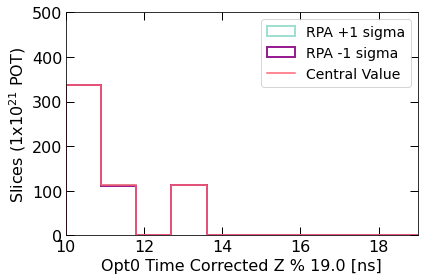

In [37]:
nu_multisigma_pos1_arr = []
nu_multisigma_neg1_arr = []
    
for name in multisigma_list:
    
    #check if weight contains anything other than 1
    pos1_reweight = all(p == 1 for p in df_nu[name+"_pos1"])
    neg1_reweight = all(p == 1 for p in df_nu[name+"_neg1"])

    
    if ( (pos1_reweight == False) or (neg1_reweight == False)):

        fig, ax = plt.subplots(1,1, figsize = (6,4))

        xmin, xmax, xnbin = xmin, xmax, xnbin
        xlimmin, xlimmax = xmin, xmax
        #-----------------------------------------------------------------#
        pltdf = df_nu['mod_t']
        
        #-----------------------------------------------------------------#
        weights = df_nu['scale_pot'] * df_nu[name+"_pos1"]
        label = name.split("_")[3]
    
        nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            #alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label +" +1 sigma"
                        )
        nu_multisigma_pos1_arr.append(nu_n)
        #-----------------------------------------------------------------#
        #for name in multisigma_list:
        weights = df_nu['scale_pot'] * df_nu[name+"_neg1"]
        label = name.split("_")[3]
    
        nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["Purple"],
                            #alpha = 0.2,
                            linestyle = "-",
                            linewidth = 2,
                            label = label +" -1 sigma"
                        )
        nu_multisigma_neg1_arr.append(nu_n)
        #-----------------------------------------------------------------#
        #central value
        ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")

        #-----------------------------------------------------------------#

        ax.legend(loc = 'best',fontsize = 14)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol =2)

        plot_tick(ax, 16)
        plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(nu_ymin, nu_ymax)
        #-----------------------------------------------------------------#
        fig.tight_layout()

        if ifSave:
            plt.savefig(savePath+str("nu_beam_bucket_multisigma_xsec_weight_universe"+name+".png"), dpi=200)
        plt.show()

In [38]:
nu_multisigma_neg1_sort_arr = []
nu_multisigma_pos1_sort_arr = []

for neg,pos in zip(nu_multisigma_neg1_arr, nu_multisigma_pos1_arr):

    neg_arr = []
    pos_arr = []
    
    for negItem, posItem in zip(neg, pos):
        neg_arr.append(min(negItem, posItem))
        pos_arr.append(max(negItem, posItem))
        
    nu_multisigma_neg1_sort_arr.append(neg_arr)
    nu_multisigma_pos1_sort_arr.append(pos_arr)

#print(nu_multisigma_neg1_sort_arr)
for neg,pos in zip(nu_multisigma_neg1_sort_arr, nu_multisigma_pos1_sort_arr):
    print()
    print(neg)
    print(pos)


[338.11556274036116, 112.33982916565401, 0.0, 112.70518758012042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[338.11556274036116, 113.06982719505106, 0.0, 112.70518758012042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[281.76296895030094, 112.70518758012037, 0.0, 112.70518758012037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[394.4681565304213, 112.70518758012037, 0.0, 112.70518758012037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[281.76296895030094, 112.70518758012037, 0.0, 112.70518758012037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[394.4681565304213, 112.70518758012037, 0.0, 112.70518758012037, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[338.11556274036116, 111.6574868736983, 0.0, 112.70518758012042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[338.11556274036116, 113.75288828654243, 0.0, 112.70518758012042, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [39]:
#Negative

nu_multisigma_neg1_err = abs(nu_dict['nu_cv'] - nu_multisigma_neg1_sort_arr)


#Positve

nu_multisigma_pos1_err = abs(nu_dict['nu_cv'] - nu_multisigma_pos1_sort_arr)

In [40]:
nu_dict['neg_xsec_multisigma'] = nu_multisigma_neg1_err
nu_dict['pos_xsec_multisigma'] = nu_multisigma_pos1_err

for i in range(0, 4):
    print(i)
    print(nu_dict['neg_xsec_multisigma'][i])
    print(nu_dict['pos_xsec_multisigma'][i])

0
[0.00000000e+00 3.65358414e-01 0.00000000e+00 5.68434189e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[0.00000000e+00 3.64639615e-01 0.00000000e+00 5.68434189e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
1
[56.35259379  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
[56.35259379  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
2
[56.35259379  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
[56.35259379  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]
3
[0.00000000e+00 1.04770071e+00 0.00000000e+00 5.68434189e-14
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[0.00000000e+00 1.04770071e+00 0.00000000e+00 5.68434189e-14
 0.000000

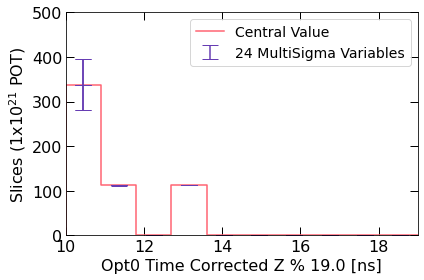

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))

#-----------------------------------------------------------------#

#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#

#universe 1 sigma
for i in range(0, nu_multisigma_neg1_err.shape[0]):
    label = ""
    if i == 0:
        label = '24 MultiSigma Variables'
    ax.errorbar(bins_mid
                , nu_dict['nu_cv']
                , [nu_dict['neg_xsec_multisigma'][i],nu_dict['pos_xsec_multisigma'][i]]
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
               )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()
if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_multisigma_1sigband.png"), dpi=200)
plt.show()

<h3>Multi Sim</h3>

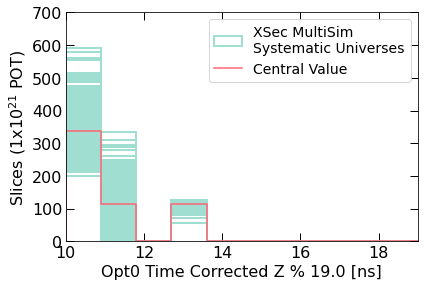

In [42]:
nu_xsec_multisim_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
#Universe
pltdf = df_nu['mod_t']

for i in range(0, 500):
    weights = df_nu['scale_pot'] * df_nu['xsecw_{}'.format(i)]
    label = ''
    if i == 0:
        label = "XSec MultiSim \nSystematic Universes"
        
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    nu_xsec_multisim_universe.append(nu_n)
    
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")

#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, 700)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_multisim_weight_universe.png"), dpi=200)
plt.show()

In [43]:
nu_xsec_multisim_universe = np.array(nu_xsec_multisim_universe)
nu_xsec_multisim_universe = np.sort(nu_xsec_multisim_universe, axis = 0)

nu_xsec_multisim_median, nu_xsec_multisim_err = get_median_68_quantile(nu_dict['nu_cv'], nu_xsec_multisim_universe)

#make array for plotting
nu_xsec_multisim_median_plot = np.insert(nu_xsec_multisim_median, 0, 0)

CV array
[338.11556274 112.70518758   0.         112.70518758   0.
   0.           0.           0.           0.           0.        ]
Weight array shape
(500, 10)

 Median
[314.33001922 108.20968093   0.         112.86142235   0.
   0.           0.           0.           0.           0.        ]

 Low 34.1 quantile
[227.87312845  59.86749928   0.         104.04437059   0.
   0.           0.           0.           0.           0.        ]

 High 34.1 quantile
[394.54497867 170.49608436   0.         118.85861409   0.
   0.           0.           0.           0.           0.        ]

 Standard Error
[[110.24243429  52.8376883    0.           8.66081699   0.
    0.           0.           0.           0.           0.        ]
 [ 56.42941593  57.79089678   0.           6.15342651   0.
    0.           0.           0.           0.           0.        ]]


In [44]:
nu_dict['neg_xsec_multisim'] = nu_xsec_multisim_err[0]
nu_dict['pos_xsec_multisim'] = nu_xsec_multisim_err[1]
nu_dict

{'nu_cv': array([338.11556274, 112.70518758,   0.        , 112.70518758,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]),
 'nu_cv_plot': array([  0.        , 338.11556274, 112.70518758,   0.        ,
        112.70518758,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]),
 'bins': array([10. , 10.9, 11.8, 12.7, 13.6, 14.5, 15.4, 16.3, 17.2, 18.1, 19. ]),
 'bins_mid': array([10.45, 11.35, 12.25, 13.15, 14.05, 14.95, 15.85, 16.75, 17.65,
        18.55]),
 'neg_stat_err': array([18.38791893, 10.61626995,  0.        , 10.61626995,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'pos_stat_err': array([18.38791893, 10.61626995,  0.        , 10.61626995,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 'neg_flx_err': array([57.08540541, 51.07843838,  0.        ,  9.92444033,  0.        ,
         0.        ,  0.       

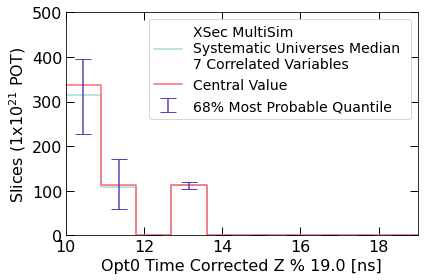

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_xsec_multisim_median_plot, color = col_dict['PastelGreen'], label = "XSec MultiSim \nSystematic Universes Median \n7 Correlated Variables")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_xsec_multisim_err
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_multisim_weight_median68.png"), dpi=200)
plt.show()

<h3> Quadrature Sum All Xsec Systematics </h3>

In [46]:
# function to calculate the sum of an array
def quadratureSumArray(arr):
    quadSum = 0
    
    for element in arr: 
        quadSum = quadSum + element**2
        
    return np.sqrt(quadSum)

In [47]:
#Negative
nu_dict['neg_xsec_multisim'] = nu_dict['neg_xsec_multisim'].reshape(1,10)

nu_xsec_neg = np.append(nu_dict['neg_xsec_multisim'], nu_dict['neg_xsec_multisigma'], axis=0)
print(nu_xsec_neg.shape)
#print(nu_xsec_neg)

nu_xsec_neg_quadSum = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_xsec_neg)

print(nu_xsec_neg_quadSum.shape)
print(nu_xsec_neg_quadSum)

nu_dict['neg_xsec_quadSum'] = nu_xsec_neg_quadSum


(5, 10)
(10,)
[136.03170208  52.84933745   0.           8.66081699   0.
   0.           0.           0.           0.           0.        ]


In [48]:
#Positive
nu_dict['pos_xsec_multisim'] = nu_dict['pos_xsec_multisim'].reshape(1,10)

nu_xsec_pos = np.append(nu_dict['pos_xsec_multisim'], nu_dict['pos_xsec_multisigma'], axis=0)
print(nu_xsec_pos.shape)
#print(nu_xsec_neg)

nu_xsec_pos_quadSum = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_xsec_pos)

print(nu_xsec_pos_quadSum.shape)
print(nu_xsec_pos_quadSum)

nu_dict['pos_xsec_quadSum'] = nu_xsec_pos_quadSum


(5, 10)
(10,)
[97.64992901 57.80154314  0.          6.15342651  0.          0.
  0.          0.          0.          0.        ]


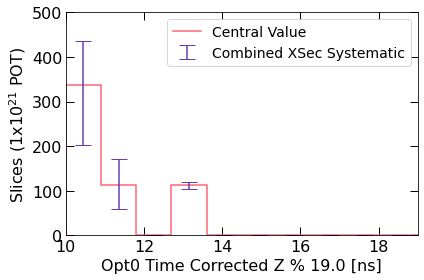

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'], nu_dict['pos_xsec_quadSum']],
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Combined XSec Systematic"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_combined.png"), dpi=200)
plt.show()

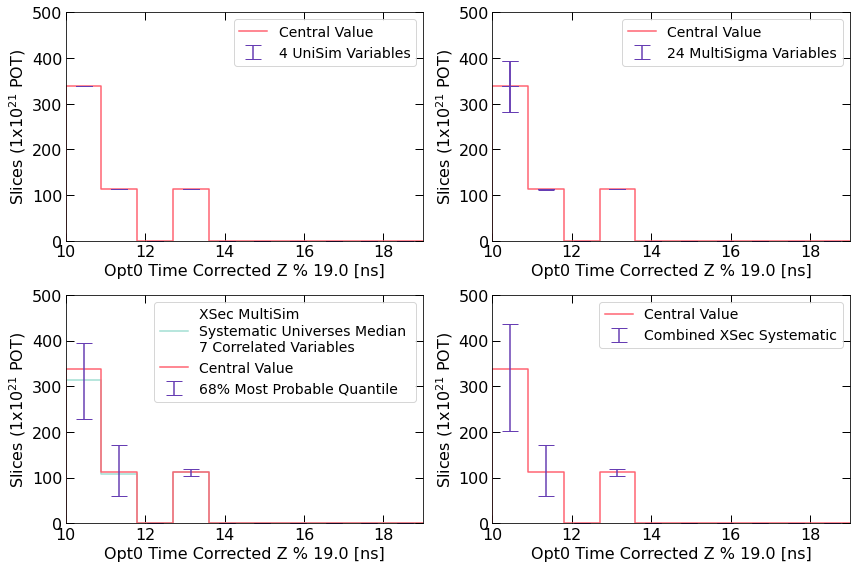

In [50]:
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (12,8))#, sharex = True, sharey = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#========================================================================#
#UNISIM
#central value
ax1.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#TODO: CURRENTLY PLOTTING 
#universe 1 sigma
for i in range(0, nu_unisim_err.shape[0]):
    label = ""
    if i == 0:
        label = '4 UniSim Variables'
    ax1.errorbar(bins_mid, nu_dict['nu_cv']
                , yerr=(np.maximum(0, - nu_unisim_err[i]), np.maximum(0, nu_unisim_err[i]))
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
                )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax1,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax1, 16)

ax1.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)

#========================================================================#
#MULTISIGMA
#central value
ax2.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#

#universe 1 sigma
for i in range(0, nu_multisigma_neg1_err.shape[0]):
    label = ""
    if i == 0:
        label = '24 MultiSigma Variables'
    ax2.errorbar(bins_mid
                , nu_dict['nu_cv']
                , [nu_dict['neg_xsec_multisigma'][i],nu_dict['pos_xsec_multisigma'][i]]
                , ls='none'
                , color = col_dict['Mauve']
                , capsize=8
                , label = label
               )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax2, 16)

ax2.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(nu_ymin, nu_ymax)

#========================================================================#
#MULTISIM
#median
ax3.step(bins, nu_xsec_multisim_median_plot, color = col_dict['PastelGreen'], label = "XSec MultiSim \nSystematic Universes Median \n7 Correlated Variables")
#-----------------------------------------------------------------#
#central value
ax3.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax3.errorbar(bins_mid, nu_dict['nu_cv']
            , nu_xsec_multisim_err
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            ,label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax3,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax3, 16)

ax3.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax3.set_xlim(xmin, xmax)
ax3.set_ylim(nu_ymin, nu_ymax)

#========================================================================#
#COMBINED
#central value
ax4.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax4.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'], nu_dict['pos_xsec_quadSum']],
            ls='none',
            color = col_dict['Mauve'],
            capsize=8
            ,label = "Combined XSec Systematic"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax4,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax4, 16)

ax4.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax4.set_xlim(xmin, xmax)
ax4.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_xsec_weight_all.png"), dpi=200)
plt.show()

<h1>Geant4 ReInteractions Weights</h1>

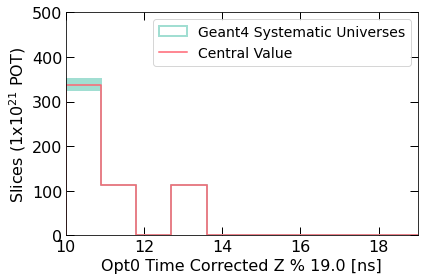

In [51]:
nu_g4_multisim_universe = []

fig, ax = plt.subplots(1,1, figsize = (6,4))

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#-----------------------------------------------------------------#
pltdf = df_nu['mod_t']

for i in range(0, 1000):
    weights = df_nu['scale_pot'] * df_nu['g4w_{}'.format(i)]
    label = ''
    if i == 0:
        label = "Geant4 Systematic Universes"
        
    nu_n, _, _ = ax.hist(
                            pltdf,
                            bins = np.arange(xmin, xmax+(xmax-xmin)/xnbin, (xmax-xmin)/xnbin),
                            weights = weights,
                            density = False,
                            histtype="step",
                            edgecolor = col_dict["PastelGreen"],
                            linestyle = "-",
                            linewidth = 2,
                            label = label
                        )
    nu_g4_multisim_universe.append(nu_n)
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
ax.legend(loc = 'upper right',fontsize = 14)

plot_tick(ax, 16)
plot_title(ax, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_g4_multisim_weight_universe.png"), dpi=200)
plt.show()

In [52]:
nu_g4_multisim_universe = np.array(nu_g4_multisim_universe)
nu_g4_multisim_universe = np.sort(nu_g4_multisim_universe, axis = 0)

nu_g4_multisim_median, nu_g4_multisim_err = get_median_68_quantile(nu_dict['nu_cv'], nu_g4_multisim_universe)

#make array for plotting
nu_g4_multisim_median_plot = np.insert(nu_g4_multisim_median, 0, 0)

CV array
[338.11556274 112.70518758   0.         112.70518758   0.
   0.           0.           0.           0.           0.        ]
Weight array shape
(1000, 10)

 Median
[338.02301226 112.7044587    0.         112.70518758   0.
   0.           0.           0.           0.           0.        ]

 Low 34.1 quantile
[334.52614671 112.69312274   0.         112.70518758   0.
   0.           0.           0.           0.           0.        ]

 High 34.1 quantile
[341.6727525  112.7166811    0.         112.70518758   0.
   0.           0.           0.           0.           0.        ]

 Standard Error
[[3.58941603e+00 1.20648359e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.55718976e+00 1.14935199e-02 0.00000000e+00 5.68434189e-14
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [53]:
nu_dict['neg_g4_err'] = nu_g4_multisim_err[0]
nu_dict['pos_g4_err'] = nu_g4_multisim_err[1]
nu_dict.keys()

dict_keys(['nu_cv', 'nu_cv_plot', 'bins', 'bins_mid', 'neg_stat_err', 'pos_stat_err', 'neg_flx_err', 'pos_flx_err', 'neg_xsec_multisigma', 'pos_xsec_multisigma', 'neg_xsec_multisim', 'pos_xsec_multisim', 'neg_xsec_quadSum', 'pos_xsec_quadSum', 'neg_g4_err', 'pos_g4_err'])

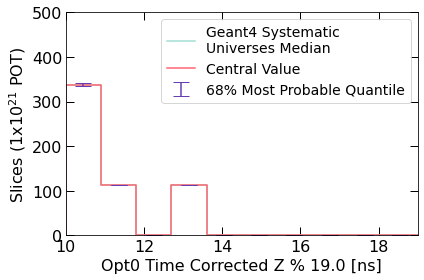

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (6, 4))
#-----------------------------------------------------------------#
#median
ax.step(bins, nu_g4_multisim_median_plot , color = col_dict['PastelGreen'], label = "Geant4 Systematic \nUniverses Median")
#-----------------------------------------------------------------#
#central value
ax.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = "Central Value")
#-----------------------------------------------------------------#
#universe 1 sigma
ax.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_g4_err'], nu_dict['pos_g4_err']]
            , ls='none'
            , color = col_dict['Mauve']
            , capsize=8
            , label = "68% Most Probable Quantile"
           )
#-----------------------------------------------------------------#
#tick stuff
plot_title(ax,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "Slices (1x10$^{21}$ POT)", 16)
plot_tick(ax, 16)

ax.legend(loc="best", fontsize=14, fancybox=True, ncol = 1)

ax.set_xlim(xmin, xmax)
ax.set_ylim(nu_ymin, nu_ymax)
#-----------------------------------------------------------------#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_g4_multisim_weight_median68.png"), dpi=200)
plt.show()

<h1>Plot Everything</h1>

<h3>HNL</h3>

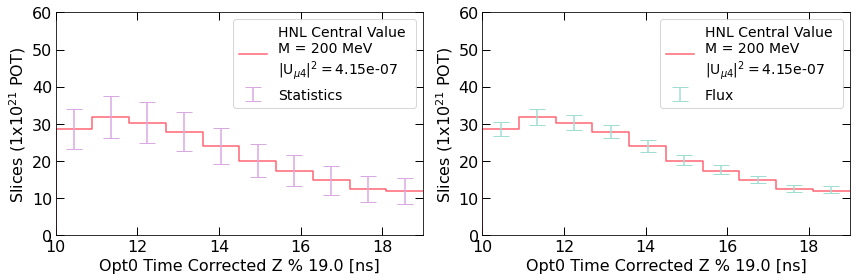

In [55]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))#, sharex = True, sharey = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#
#STATS
ax1.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(plotU))
        )

ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_stat_err'],hnl_dict['pos_stat_err']]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            , label = "Statistics"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax)

#=========================================================================#
#FLUX
#-----------------------------------------------------------------#
#central value
ax2.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(plotU)))
#-----------------------------------------------------------------#
#universe 1 sigma
ax2.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_flx_err'],hnl_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            ,label = "Flux"
           )

#-----------------------------------------------------------------#
ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(hnl_ymin, hnl_ymax)

#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_standard_error.png"), dpi=200)
    
plt.show()

In [56]:
hnl_dict['neg_stat_err'] = hnl_dict['neg_stat_err'].reshape(1,10)
hnl_dict['neg_flx_err'] = hnl_dict['neg_flx_err'].reshape(1,10)

hnl_neg_err = np.append(hnl_dict['neg_stat_err']
                        , hnl_dict['neg_flx_err']
                        , axis=0)

print("\n Negative Direction")
print(hnl_neg_err)
#------------------------------------------------------------------#

hnl_dict['pos_flx_err'] = hnl_dict['pos_flx_err'].reshape(1,10)
hnl_dict['pos_stat_err'] = hnl_dict['pos_stat_err'].reshape(1,10)

hnl_pos_err = np.append(hnl_dict['pos_stat_err']
                        , hnl_dict['pos_flx_err']
                        , axis=0)

print("\n Positive Direction")
print(hnl_pos_err)
#------------------------------------------------------------------#
hnl_neg_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_neg_err)

hnl_dict['neg_quadSum_err'] = hnl_neg_quad_err
#------------------------------------------------------------------#

hnl_pos_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_pos_err)

hnl_dict['pos_quadSum_err'] = hnl_pos_quad_err


 Negative Direction
[[5.35338446 5.65071644 5.50514322 5.2769999  4.89427398 4.48162804
  4.16682265 3.84798752 3.52063895 3.46594609]
 [1.92477003 2.14170248 1.95454813 1.78826823 1.46529893 1.23813414
  0.93941363 0.79283857 0.60511934 0.56935044]]

 Positive Direction
[[5.35338446 5.65071644 5.50514322 5.2769999  4.89427398 4.48162804
  4.16682265 3.84798752 3.52063895 3.46594609]
 [1.82107433 1.94456988 2.01936317 1.8812022  1.68579602 1.46079761
  1.46990415 1.22981003 1.19652803 1.19544627]]


In [57]:
#FOR PLOTTING

#Stat
hnl_stat_neg_diff = ((hnl_dict['hnl_cv'] - hnl_dict['neg_stat_err'])  -  hnl_dict['hnl_cv'] ) / hnl_dict['hnl_cv'] * 100
hnl_stat_neg_diff = np.insert(hnl_stat_neg_diff, 0, 0)

hnl_stat_pos_diff = ((hnl_dict['hnl_cv'] + hnl_dict['pos_stat_err'])  -  hnl_dict['hnl_cv'] ) / hnl_dict['hnl_cv'] * 100
hnl_stat_pos_diff = np.insert(hnl_stat_pos_diff, 0, 0)

#Flux
hnl_flx_neg_diff = ((hnl_dict['hnl_cv'] - hnl_dict['neg_flx_err'])  -  hnl_dict['hnl_cv'] ) / hnl_dict['hnl_cv'] * 100
hnl_flx_neg_diff = np.insert(hnl_flx_neg_diff, 0, 0)

hnl_flx_pos_diff = ((hnl_dict['hnl_cv'] + hnl_dict['pos_flx_err'])  -  hnl_dict['hnl_cv'] ) / hnl_dict['hnl_cv'] * 100
hnl_flx_pos_diff = np.insert(hnl_flx_pos_diff, 0, 0)

#Quad Sum
hnl_quadsum_neg_diff = ((hnl_dict['hnl_cv'] + hnl_dict['pos_quadSum_err'])  -  hnl_dict['hnl_cv'] ) / hnl_dict['hnl_cv'] * 100
hnl_quadsum_neg_diff = np.insert(hnl_quadsum_neg_diff, 0, 0)

hnl_quadsum_pos_diff = ((hnl_dict['hnl_cv'] - hnl_dict['neg_quadSum_err'])  -  hnl_dict['hnl_cv'] ) / hnl_dict['hnl_cv'] * 100
hnl_quadsum_pos_diff = np.insert(hnl_quadsum_pos_diff, 0, 0)

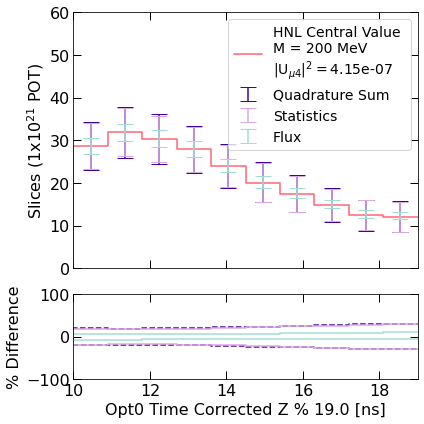

In [58]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#

ax1.step(bins, hnl_dict['hnl_cv_plot'], color = col_dict['Flamingo']
         , label =  "HNL Central Value \nM = 200 MeV\n|U$_{\mu4}|^{2} = $" +str("{:.3g}".format(plotU))
        )
#-----------------------------------------------------------------#
#QuadSum
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_quadSum_err'], hnl_dict['pos_quadSum_err']]
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            ,label = "Quadrature Sum"
           )
#-----------------------------------------------------------------#
#STATS
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_stat_err'].flatten(), hnl_dict['pos_stat_err'].flatten()]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            ,label = "Statistics"
           )
#-----------------------------------------------------------------#
#Flux
ax1.errorbar(bins_mid, hnl_dict['hnl_cv']
            , [hnl_dict['neg_flx_err'].flatten(), hnl_dict['pos_flx_err'].flatten()]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            ,label = "Flux"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", '',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(hnl_ymin, hnl_ymax)
#=========================================================================#
#-----------------------------------------------------------------#
#QuadSum
ax2.step(bins, hnl_quadsum_neg_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, hnl_quadsum_pos_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, hnl_stat_neg_diff
         , color = col_dict['Lavender']
        )

ax2.step(bins, hnl_stat_pos_diff
         , color = col_dict['Lavender']
        )
#-----------------------------------------------------------------#
#Flux
ax2.step(bins, hnl_flx_neg_diff
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, hnl_flx_pos_diff
         , color = col_dict['PastelGreen']
        )

#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "% Difference", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-100, 100)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("hnl_beam_bucket_combined_standard_error.png"), dpi=200)
    
plt.show()

<h3>Neutrino</h3>

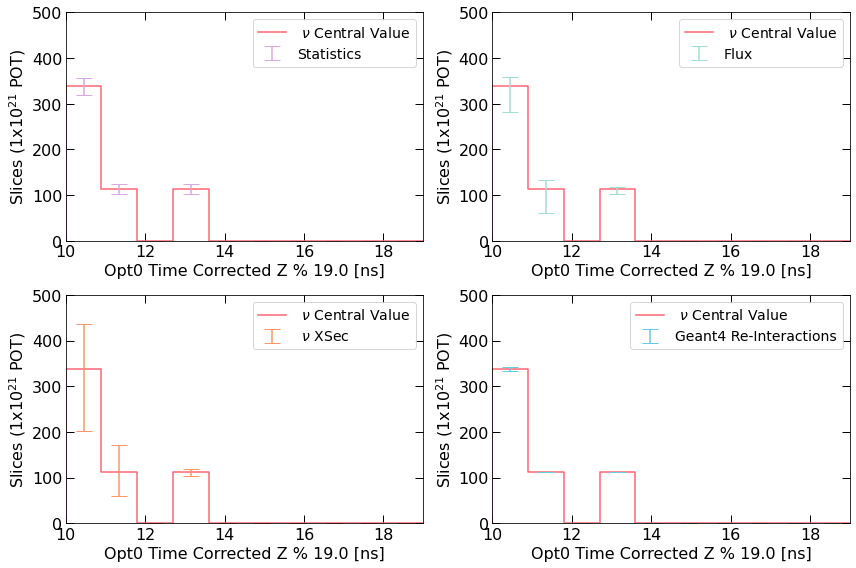

In [59]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2, figsize = (12,8))#, sharey = True, sharex= True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax
#=========================================================================#
#STATS
#-----------------------------------------------------------------#
#central value
ax1.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_stat_err'],nu_dict['pos_stat_err']]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            , label = "Statistics"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)

#=========================================================================#
#FLUX
#-----------------------------------------------------------------#
#central value
ax2.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

#-----------------------------------------------------------------#
#universe 1 sigma
ax2.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_flx_err'],nu_dict['pos_flx_err']]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            , label = "Flux"
           )

#-----------------------------------------------------------------#
ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax2.set_xlim(xmin, xmax)
ax2.set_ylim(nu_ymin, nu_ymax)

#=========================================================================#
#XSEC
#-----------------------------------------------------------------#
#central value
ax3.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

#-----------------------------------------------------------------#
#universe 1 sigma
ax3.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'],nu_dict['pos_xsec_quadSum']]
            , ls='none'
            , color = col_dict['Peach']
            , capsize=8
            , label = r" $\nu$ XSec"
           )

#-----------------------------------------------------------------#
ax3.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax3, 16)
plot_title(ax3, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax3.set_xlim(xmin, xmax)
ax3.set_ylim(nu_ymin, nu_ymax)
#=========================================================================#
#G4
#-----------------------------------------------------------------#
#central value
ax4.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")

#-----------------------------------------------------------------#
#universe 1 sigma
ax4.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_g4_err'],nu_dict['pos_g4_err']]
            , ls='none'
            , color = col_dict['SkyBlue']
            , capsize=8
            , label = "Geant4 Re-Interactions"
           )

#-----------------------------------------------------------------#
ax4.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax4, 16)
plot_title(ax4, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax4.set_xlim(xmin, xmax)
ax4.set_ylim(nu_ymin, nu_ymax)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_standard_error.png"), dpi=200)
    
plt.show()

In [60]:
nu_dict['neg_stat_err'] = nu_dict['neg_stat_err'].reshape(1,10)
nu_dict['neg_flx_err'] = nu_dict['neg_flx_err'].reshape(1,10)
nu_dict['neg_xsec_quadSum'] = nu_dict['neg_xsec_quadSum'].reshape(1,10)
nu_dict['neg_g4_err'] = nu_dict['neg_g4_err'].reshape(1,10)

nu_neg_err = np.append(nu_dict['neg_stat_err'], nu_dict['neg_flx_err'], axis=0)
nu_neg_err = np.append(nu_neg_err, nu_dict['neg_xsec_quadSum'], axis=0)
nu_neg_err = np.append(nu_neg_err, nu_dict['neg_g4_err'], axis=0)

print("\n Negative Direction")
print(nu_neg_err)

#------------------------------------------------------------------#

nu_dict['pos_stat_err'] = nu_dict['pos_stat_err'].reshape(1,10)
nu_dict['pos_flx_err'] = nu_dict['pos_flx_err'].reshape(1,10)
nu_dict['pos_xsec_quadSum'] = nu_dict['pos_xsec_quadSum'].reshape(1,10)
nu_dict['pos_g4_err'] = nu_dict['pos_g4_err'].reshape(1,10)

nu_pos_err = np.append(nu_dict['pos_stat_err'], nu_dict['pos_flx_err'], axis=0)
nu_pos_err = np.append(nu_pos_err, nu_dict['pos_xsec_quadSum'], axis=0)
nu_pos_err = np.append(nu_pos_err, nu_dict['pos_g4_err'], axis=0)

print("\n Positive Direction")
print(nu_pos_err)

#------------------------------------------------------------------#

nu_neg_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_neg_err)

nu_dict['neg_quadSum_err'] = nu_neg_quad_err
#------------------------------------------------------------------#

nu_pos_quad_err = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_pos_err)

nu_dict['pos_quadSum_err'] = nu_pos_quad_err


 Negative Direction
[[1.83879189e+01 1.06162699e+01 0.00000000e+00 1.06162699e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.70854054e+01 5.10784384e+01 0.00000000e+00 9.92444033e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.36031702e+02 5.28493374e+01 0.00000000e+00 8.66081699e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.58941603e+00 1.20648359e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]

 Positive Direction
[[1.83879189e+01 1.06162699e+01 0.00000000e+00 1.06162699e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.01154971e+01 2.07101515e+01 0.00000000e+00 5.40073230e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.76499290e+0

In [61]:
nu_dict.keys()
print(nu_dict['neg_quadSum_err'])
print(nu_dict['pos_quadSum_err'])

[148.70900092  74.26146153   0.          16.91772604   0.
   0.           0.           0.           0.           0.        ]
[101.44412757  62.31078627   0.          13.406631     0.
   0.           0.           0.           0.           0.        ]


In [62]:
#FOR PLOTTING

#Stat
nu_stat_neg_diff = ((nu_dict['nu_cv'] - nu_dict['neg_stat_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_stat_neg_diff = np.insert(nu_stat_neg_diff, 0, 0)
#nu_stat_neg_diff[np.isnan(nu_stat_neg_diff)] = 0

nu_stat_pos_diff = ((nu_dict['nu_cv'] + nu_dict['pos_stat_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_stat_pos_diff = np.insert(nu_stat_pos_diff, 0, 0)
#nu_stat_pos_diff[np.isnan(nu_stat_pos_diff)] = 0

#Flux
nu_flx_neg_diff = ((nu_dict['nu_cv'] - nu_dict['neg_flx_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_flx_neg_diff = np.insert(nu_flx_neg_diff, 0, 0)
#nu_flx_neg_diff[np.isnan(nu_flx_neg_diff)] = 0

nu_flx_pos_diff = ((nu_dict['nu_cv'] + nu_dict['pos_flx_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_flx_pos_diff = np.insert(nu_flx_pos_diff, 0, 0)
#nu_flx_pos_diff[np.isnan(nu_flx_pos_diff)] = 0

#Quad Sum
nu_quadsum_neg_diff = ((nu_dict['nu_cv'] - nu_dict['neg_quadSum_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_quadsum_neg_diff = np.insert(nu_quadsum_neg_diff, 0, 0)
#nu_quadsum_neg_diff[np.isnan(nu_quadsum_neg_diff)] = 0

nu_quadsum_pos_diff = ((nu_dict['nu_cv'] + nu_dict['pos_quadSum_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_quadsum_pos_diff = np.insert(nu_quadsum_pos_diff, 0, 0)
#nu_quadsum_pos_diff[np.isnan(nu_quadsum_pos_diff)] = 0

#XSec
nu_xsec_neg_diff = ((nu_dict['nu_cv'] - nu_dict['neg_xsec_quadSum'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_xsec_neg_diff = np.insert(nu_xsec_neg_diff, 0, 0)
#nu_xsec_neg_diff[np.isnan(nu_xsec_neg_diff)] = 0

nu_xsec_pos_diff = ((nu_dict['nu_cv'] + nu_dict['pos_xsec_quadSum'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_xsec_pos_diff = np.insert(nu_xsec_pos_diff, 0, 0)
#nu_xsec_pos_diff[np.isnan(nu_xsec_pos_diff)] = 0

#G4
nu_g4_neg_diff = ((nu_dict['nu_cv'] - nu_dict['neg_g4_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_g4_neg_diff = np.insert(nu_g4_neg_diff, 0, 0)
#nu_g4_neg_diff[np.isnan(nu_g4_neg_diff)] = 0

nu_g4_pos_diff = ((nu_dict['nu_cv'] + nu_dict['pos_g4_err'])  -  nu_dict['nu_cv'] ) / nu_dict['nu_cv'] * 100
nu_g4_pos_diff = np.insert(nu_g4_pos_diff, 0, 0)
#nu_g4_pos_diff[np.isnan(nu_g4_pos_diff)] = 0

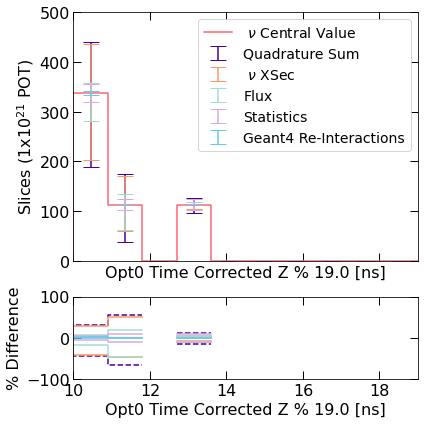

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize = (6, 6), sharex = True)

xmin, xmax, xnbin = xmin, xmax, xnbin
xlimmin, xlimmax = xmin, xmax

#-----------------------------------------------------------------#
#central value
ax1.step(bins, nu_dict['nu_cv_plot'], color = col_dict['Flamingo'], label = r" $\nu$ Central Value")
#=========================================================================#
#QuadSum
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_quadSum_err'],nu_dict['pos_quadSum_err']]
            , ls='none'
            , color = col_dict['DeepViolet']
            , capsize=8
            , label = "Quadrature Sum"
           )

#=========================================================================#
#XSEC
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_xsec_quadSum'].flatten(),nu_dict['pos_xsec_quadSum'].flatten()]
            , ls='none'
            , color = col_dict['Peach']
            , capsize=8
            , label = r" $\nu$ XSec"
           )

#=========================================================================#
#FLUX
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_flx_err'].flatten(),nu_dict['pos_flx_err'].flatten()]
            , ls='none'
            , color = col_dict['PastelGreen']
            , capsize=8
            , label = "Flux"
           )

#=========================================================================#
#STATS
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_stat_err'].flatten(),nu_dict['pos_stat_err'].flatten()]
            , ls='none'
            , color = col_dict['Lavender']
            , capsize=8
            , label = "Statistics"
           )
#=========================================================================#
#G4
ax1.errorbar(bins_mid, nu_dict['nu_cv']
            , [nu_dict['neg_g4_err'].flatten(),nu_dict['pos_g4_err'].flatten()]
            , ls='none'
            , color = col_dict['SkyBlue']
            , capsize=8
            , label = "Geant4 Re-Interactions"
           )
#-----------------------------------------------------------------#
ax1.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax1, 16)
plot_title(ax1, "", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]',  "Slices (1x10$^{21}$ POT)", 16)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(nu_ymin, nu_ymax)
#=========================================================================#
#-----------------------------------------------------------------#
#QuadSum
ax2.step(bins, nu_quadsum_neg_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )

ax2.step(bins, nu_quadsum_pos_diff
         , color = col_dict['DeepViolet'] , linestyle = '--'
        )
#-----------------------------------------------------------------#
#XSec
ax2.step(bins, nu_xsec_neg_diff
         , color = col_dict['Peach'] 
        )

ax2.step(bins, nu_xsec_pos_diff
         , color = col_dict['Peach'] 
        )
#-----------------------------------------------------------------#
#Flux
ax2.step(bins, nu_flx_neg_diff
         , color = col_dict['PastelGreen']
        )

ax2.step(bins, nu_flx_pos_diff
         , color = col_dict['PastelGreen']
        )
#-----------------------------------------------------------------#
#STATS
ax2.step(bins, nu_stat_neg_diff
         , color = col_dict['Lavender']
        )

ax2.step(bins, nu_stat_pos_diff
         , color = col_dict['Lavender']
        )

#-----------------------------------------------------------------#
#G4
ax2.step(bins, nu_g4_neg_diff
         , color = col_dict['SkyBlue']
        )

ax2.step(bins, nu_g4_pos_diff
         , color = col_dict['SkyBlue']
        )
#-----------------------------------------------------------------#

#ax2.legend(loc = 'upper right',fontsize = 14)
plot_tick(ax2, 16)
plot_title(ax2,"", 'Opt0 Time Corrected Z % ' + str(width) + ' [ns]', "% Difference", 16)


ax2.set_xlim(xmin, xmax)
ax2.set_ylim(-100, 100)
#=========================================================================#
fig.tight_layout()

if ifSave:
    plt.savefig(savePath+str("nu_beam_bucket_combined_standard_error.png"), dpi=200)
    
plt.show()

<h1> Quadrature Sum 2 Directional Error Bars Into 1 </h1>

<h3>HNL</h3>

In [67]:
hnl_dict

{'hnl_cv': array([28.65872514, 31.93059626, 30.30660184, 27.84672793, 23.95391776,
        20.08498987, 17.36241098, 14.80700799, 12.39489862, 12.01278229]),
 'hnl_cv_plot': array([ 0.        , 28.65872514, 31.93059626, 30.30660184, 27.84672793,
        23.95391776, 20.08498987, 17.36241098, 14.80700799, 12.39489862,
        12.01278229]),
 'bins': array([10. , 10.9, 11.8, 12.7, 13.6, 14.5, 15.4, 16.3, 17.2, 18.1, 19. ]),
 'bins_mid': array([10.45, 11.35, 12.25, 13.15, 14.05, 14.95, 15.85, 16.75, 17.65,
        18.55]),
 'neg_stat_err': array([[5.35338446, 5.65071644, 5.50514322, 5.2769999 , 4.89427398,
         4.48162804, 4.16682265, 3.84798752, 3.52063895, 3.46594609]]),
 'pos_stat_err': array([[5.35338446, 5.65071644, 5.50514322, 5.2769999 , 4.89427398,
         4.48162804, 4.16682265, 3.84798752, 3.52063895, 3.46594609]]),
 'neg_flx_err': array([[1.92477003, 2.14170248, 1.95454813, 1.78826823, 1.46529893,
         1.23813414, 0.93941363, 0.79283857, 0.60511934, 0.56935044]]),
 'po

In [68]:
hnl_negpos_stat_arr = np.append(hnl_dict['neg_stat_err']
                        , hnl_dict['pos_stat_err']
                        , axis=0)

hnl_dict['negpos_stat_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_negpos_stat_arr)

#------------------------------------------------------------------#
hnl_negpos_flx_arr = np.append(hnl_dict['neg_flx_err']
                        , hnl_dict['pos_flx_err']
                        , axis=0)

hnl_dict['negpos_flx_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_negpos_flx_arr)

#------------------------------------------------------------------#
hnl_negpos_quadSum_arr = np.append(hnl_dict['neg_quadSum_err'].reshape(1,10)
                        , hnl_dict['pos_quadSum_err'].reshape(1,10)
                        , axis=0)


hnl_dict['negpos_quadSum_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=hnl_negpos_quadSum_arr)

#------------------------------------------------------------------#

print('\n Stat')
print(hnl_negpos_stat_arr)
print(hnl_dict['negpos_stat_err'])

print('\n Flux')
print(hnl_negpos_flx_arr)
print(hnl_dict['negpos_flx_err'])

print('\n QuadSum')
print(hnl_negpos_quadSum_arr)
print(hnl_dict['negpos_quadSum_err'])


 Stat
[[5.35338446 5.65071644 5.50514322 5.2769999  4.89427398 4.48162804
  4.16682265 3.84798752 3.52063895 3.46594609]
 [5.35338446 5.65071644 5.50514322 5.2769999  4.89427398 4.48162804
  4.16682265 3.84798752 3.52063895 3.46594609]]
[7.5708289  7.99131982 7.7854482  7.46280482 6.92154864 6.33797915
 5.8927771  5.44187615 4.97893535 4.90158796]

 Flux
[[1.92477003 2.14170248 1.95454813 1.78826823 1.46529893 1.23813414
  0.93941363 0.79283857 0.60511934 0.56935044]
 [1.82107433 1.94456988 2.01936317 1.8812022  1.68579602 1.46079761
  1.46990415 1.22981003 1.19652803 1.19544627]]
[2.64972666 2.89279131 2.81035336 2.59553944 2.233609   1.91491666
 1.74445297 1.46322442 1.34083882 1.32410412]

 QuadSum
[[5.6888896  6.04296995 5.84181994 5.57177092 5.10891561 4.64951245
  4.27140597 3.92881674 3.57226371 3.51239836]
 [5.65464737 5.97594748 5.86382379 5.60228968 5.17646848 4.71369489
  4.41848721 4.03973275 3.71841068 3.66631615]]
[8.02112845 8.49879015 8.27715469 7.90128349 7.2730217  6

<h3>Neutrino</h3>

In [69]:
nu_dict.keys()

dict_keys(['nu_cv', 'nu_cv_plot', 'bins', 'bins_mid', 'neg_stat_err', 'pos_stat_err', 'neg_flx_err', 'pos_flx_err', 'neg_xsec_multisigma', 'pos_xsec_multisigma', 'neg_xsec_multisim', 'pos_xsec_multisim', 'neg_xsec_quadSum', 'pos_xsec_quadSum', 'neg_g4_err', 'pos_g4_err', 'neg_quadSum_err', 'pos_quadSum_err'])

In [70]:
nu_negpos_stat_arr = np.append(nu_dict['neg_stat_err']
                        , nu_dict['pos_stat_err']
                        , axis=0)

nu_dict['negpos_stat_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_stat_arr)

#------------------------------------------------------------------#
nu_negpos_flx_arr = np.append(nu_dict['neg_flx_err']
                        , nu_dict['pos_flx_err']
                        , axis=0)

nu_dict['negpos_flx_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_flx_arr)

#------------------------------------------------------------------#
nu_negpos_xsec_arr = np.append(nu_dict['neg_xsec_quadSum']
                        , nu_dict['pos_xsec_quadSum']
                        , axis=0)

nu_dict['negpos_xsec_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_xsec_arr)

#------------------------------------------------------------------#
nu_negpos_g4_arr = np.append(nu_dict['neg_g4_err']
                        , nu_dict['pos_g4_err']
                        , axis=0)

nu_dict['negpos_g4_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_g4_arr)

#------------------------------------------------------------------#
nu_negpos_quadSum_arr = np.append(nu_dict['neg_quadSum_err'].reshape(1,10)
                        , nu_dict['pos_quadSum_err'].reshape(1,10)
                        , axis=0)


nu_dict['negpos_quadSum_err'] = np.apply_along_axis(quadratureSumArray, axis=0, arr=nu_negpos_quadSum_arr)

#------------------------------------------------------------------#

print('\n Stat')
print(nu_negpos_stat_arr)
print(nu_dict['negpos_stat_err'])

print('\n Flux')
print(nu_negpos_flx_arr)
print(nu_dict['negpos_flx_err'])

print('\n XSec')
print(nu_negpos_xsec_arr)
print(nu_dict['negpos_xsec_err'])

print('\n QuadSum')
print(nu_negpos_quadSum_arr)
print(nu_dict['negpos_quadSum_err'])


 Stat
[[18.38791893 10.61626995  0.         10.61626995  0.          0.
   0.          0.          0.          0.        ]
 [18.38791893 10.61626995  0.         10.61626995  0.          0.
   0.          0.          0.          0.        ]]
[26.00444434 15.01367294  0.         15.01367294  0.          0.
  0.          0.          0.          0.        ]

 Flux
[[57.08540541 51.07843838  0.          9.92444033  0.          0.
   0.          0.          0.          0.        ]
 [20.11549705 20.71015153  0.          5.4007323   0.          0.
   0.          0.          0.          0.        ]]
[60.52583525 55.11730439  0.         11.29877981  0.          0.
  0.          0.          0.          0.        ]

 XSec
[[136.03170208  52.84933745   0.           8.66081699   0.
    0.           0.           0.           0.           0.        ]
 [ 97.64992901  57.80154314   0.           6.15342651   0.
    0.           0.           0.           0.           0.        ]]
[167.45188147  78.320309

<h1>Save Array</h1>

In [71]:
hnl_dict_save = {}
hnl_dict_save = {
    m :{ 
        'U': fitU,
        'sig': hnl_dict['hnl_cv'].tolist(),
    
        'sig_stat': list(np.concatenate(hnl_dict['neg_stat_err'].tolist())),
    
        'sig_flx_lo': list(np.concatenate( (hnl_dict['hnl_cv'] - hnl_dict['neg_flx_err']).tolist())),
        'sig_flx_hi': list(np.concatenate( (hnl_dict['hnl_cv'] + hnl_dict['pos_flx_err']).tolist())),
        'sig_flx_quadSum': hnl_dict['negpos_flx_err'].tolist(),

        'sig_quadSum_lo': (hnl_dict['hnl_cv'] - hnl_dict['neg_quadSum_err']).tolist(),
        'sig_quadSum_hi': (hnl_dict['hnl_cv'] + hnl_dict['pos_quadSum_err']).tolist(),
        'sig_quadSum': hnl_dict['negpos_quadSum_err'].tolist(),
    
        'bkg': nu_dict['nu_cv'].tolist(),
        
        'bkg_stat': list(np.concatenate(nu_dict['neg_stat_err'].tolist())),
        
        'bkg_flx_lo': list(np.concatenate( (nu_dict['nu_cv'] - nu_dict['neg_flx_err']).tolist())),
        'bkg_flx_hi': list(np.concatenate( (nu_dict['nu_cv'] + nu_dict['pos_flx_err']).tolist())),
        'bkg_flx_quadSum': nu_dict['negpos_flx_err'].tolist(),
           
        'bkg_xsec_lo': list(np.concatenate( (nu_dict['nu_cv'] - nu_dict['neg_xsec_quadSum']).tolist())),
        'bkg_xsec_hi': list(np.concatenate( (nu_dict['nu_cv'] + nu_dict['pos_xsec_quadSum']).tolist())),
        'bkg_xsec_quadSum': nu_dict['negpos_xsec_err'].tolist(),
        
        'bkg_g4_lo': list(np.concatenate( (nu_dict['nu_cv'] - nu_dict['neg_g4_err']).tolist())),
        'bkg_g4_hi': list(np.concatenate( (nu_dict['nu_cv'] + nu_dict['pos_g4_err']).tolist())),
        'bkg_g4_quadSum': nu_dict['negpos_g4_err'].tolist(),
        
        'bkg_quadSum_lo': (nu_dict['nu_cv'] - nu_dict['neg_quadSum_err']).tolist(),
        'bkg_quadSum_hi': (nu_dict['nu_cv'] + nu_dict['pos_quadSum_err']).tolist(),
        'bkg_quadSum': nu_dict['negpos_quadSum_err'].tolist()
        }
    
}

In [72]:
for k, v in hnl_dict_save[m].items():
    print(k ,v)
    print('\n')

U 4.147288270665544e-08


sig [28.65872514021824, 31.930596260393077, 30.306601835780718, 27.846727927911985, 23.95391776304109, 20.08498986911485, 17.362410980792504, 14.80700798912153, 12.394898623151732, 12.012782287948596]


sig_stat [5.353384456604835, 5.650716437797342, 5.505143216645751, 5.276999898418796, 4.894273977112549, 4.481628037791049, 4.166822648108808, 3.8479875245537802, 3.520638950979173, 3.4659460884365463]


sig_flx_lo [26.733955105622204, 29.788893780301443, 28.352053705291038, 26.05845969826435, 22.488618835104955, 18.846855726906636, 16.42299735558367, 14.01416942214097, 11.78977928478364, 11.443431843628245]


sig_flx_hi [30.47979946676254, 33.87516614325847, 32.32596500946886, 29.72793013137025, 25.639713778362523, 21.54578747505341, 18.83231512919082, 16.03681802127569, 13.591426657199076, 13.208228561396485]


sig_flx_quadSum [2.6497266630499077, 2.8927913064335935, 2.810353362417002, 2.5955394413230017, 2.2336089974488393, 1.9149166560499429, 1.744452970047

In [73]:
np.save("./m"+str(m)+"_v2.npy", hnl_dict_save) 

###### 